In [16]:
# 패키지 선언
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import time
import os

In [17]:
print(tf.__version__)

2.1.0


In [18]:
# 이미지를 그리는 함수
def display_image(image):
  fig = plt.figure(figsize=(10, 8))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(image)

In [19]:
# 이미지에 박스를 그리는 함수
# PIL 패키지를 사용해 그림
def draw_bounding_box_on_image(image, ymin, xmin, ymax,
                               xmax, color, font, thickness=4,
                               display_str_list=()):

  # 이미지에 경계상자 그리기
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size #이미지 원사이즈
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],width=thickness, fill=color)

  # 이미지 상단에 글자넣기
  # 만약 박스이미지가 이미지를 초과하면 하단에 글씨를 넣는다
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  # 각각의 디스플레이마다 상단과 하단의 여백을 0.05로 설정한다.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)

    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,fill="black",font=font)
    text_bottom -= text_height - 2 * margin

In [20]:
#박스 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  # 폰트 지정
  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score: #최소의 값 이상인 값 찾기
      ymin, xmin, ymax, xmax = tuple(boxes[i]) #박스 좌표값 
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))

      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,ymin,xmin,
          ymax,xmax,color,
          font,display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [21]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 
detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [22]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [24]:
import cv2

def run_detector(detector, path):
  for f in os.listdir(path):
    if f.split('.')[1] =='jpg':
      img=cv2.imread(path+'/'+f)
      img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      
      converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
      start_time = time.time()
      result = detector(converted_img)
      end_time = time.time()
      result = {key:value.numpy() for key,value in result.items()}
      print("이미지에서 찾은 %d개의 객체." % len(result["detection_scores"]))
      print("추론한 시간: ", end_time-start_time)

      image_with_boxes = draw_boxes(
          img, result["detection_boxes"],
          result["detection_class_entities"], result["detection_scores"])

      display_image(image_with_boxes)

이미지에서 찾은 100개의 객체.
추론한 시간:  99.03604316711426
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  37.096752882003784
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  43.628278970718384
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  41.78221797943115
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  42.051496744155884
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  37.99734377861023
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  36.62301445007324
Font not found, using default font.
이미지에서 찾은 100개의 객체.
추론한 시간:  42.34670829772949
Font not found, using default font.


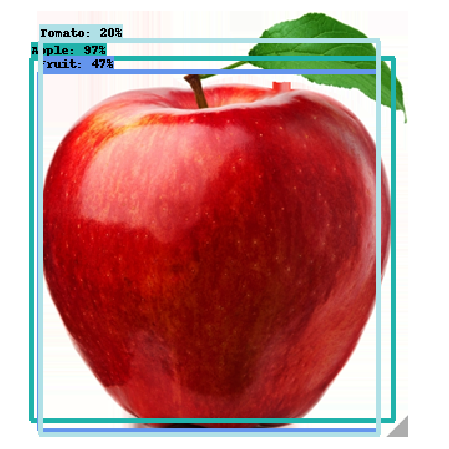

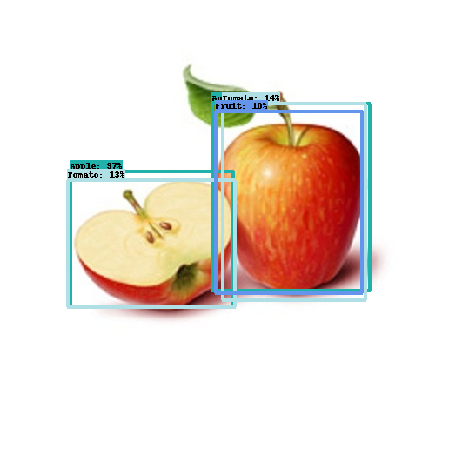

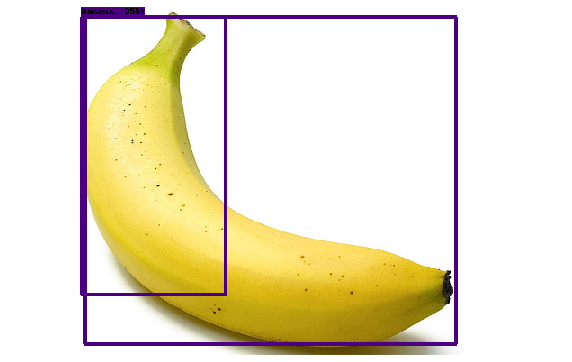

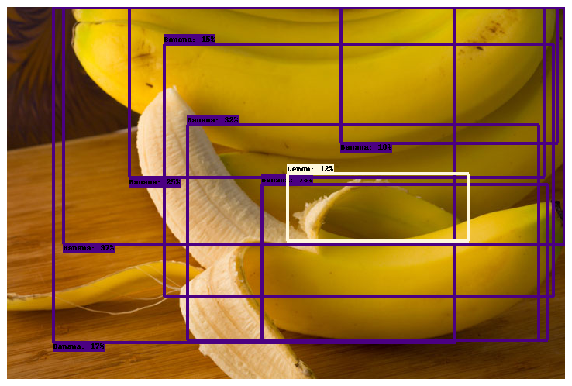

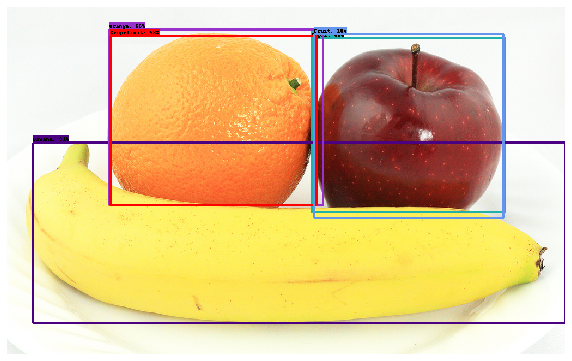

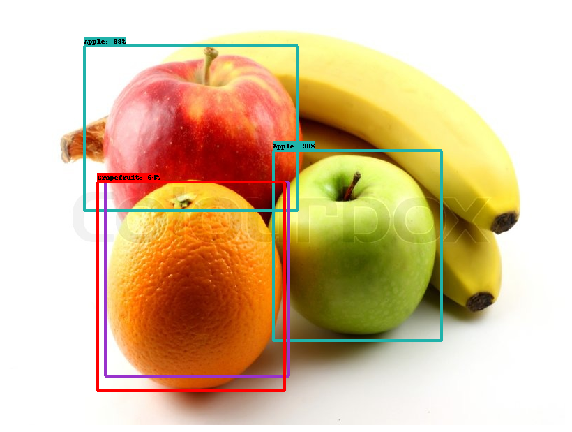

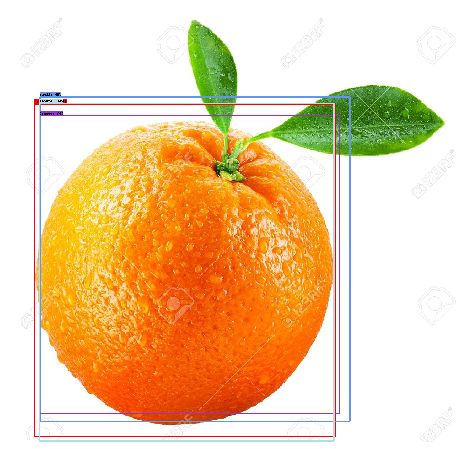

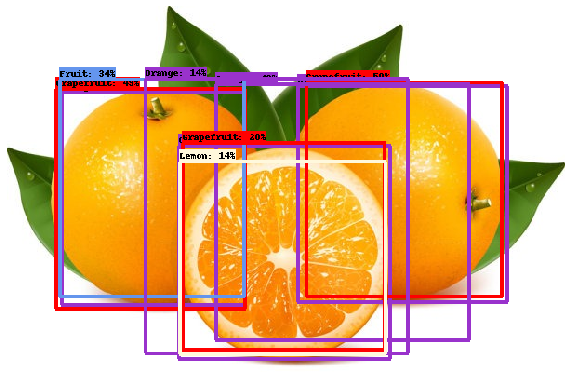

In [25]:
# 실행
# sample 폴더에 클래스별로 이미지 2개씩 넣음

path='C:/Users/hansu/Code/Study/data/fruit-images-for-object-detection/sample'
run_detector(detector, path)